Now, we can try to make sense of some shapefiles and get them into a format where we can apply our algorithm. First, let's install a library that allows us to work easily with shapefiles! I chose `pyshp`.

In [1]:
!pip install pyshp

You should consider upgrading via the 'c:\users\mark\anaconda3\python.exe -m pip install --upgrade pip' command.


Now we can load in our shapefile and set up our reader.

In [45]:
import shapefile
import os
myshp = open("C:\\Users\\Mark\\Desktop\\coastline-capstone\\LA_shorelines.shp", "rb")
mydbf = open("C:\\Users\\Mark\\Desktop\\coastline-capstone\\LA_shorelines.dbf", "rb")

r = shapefile.Reader(shp=myshp, dbf=mydbf)
shapes = r.shapes()

Just to get a sense of what this shapefile looks like, we can plot each shape.

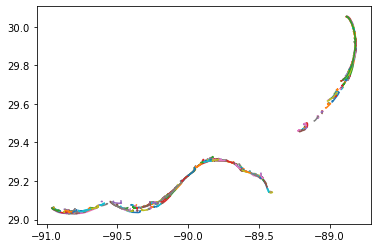

In [46]:
import matplotlib.pyplot as plt

plt.figure()
for shape in r.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y)
plt.show()

Now, we can do some transformations on the coordinates to make them more usable for our purposes. Since the coordinates have a lot of decimals and our 2D array approach requires integer coordinates, we can multiply each coordinate by some amount and round off the excess.

In [47]:
shape_coords = []
for shape in shapes:
    shape_coords.append(shape.bbox)

In [48]:
rounded_coords = []
for bbox in shape_coords:
    bbox = list(map(lambda x: round(x*1000), bbox))
    rounded_coords.append(bbox)

Each shape is given as a boundary box - to simplify this, we can individually average the x values and the y values of each boundary box.

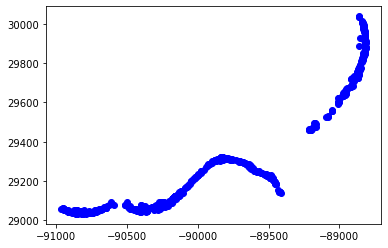

In [49]:
plt.figure()
for i in range(len(rounded_coords)):
    coords = rounded_coords[i]
    x = (coords[0]+coords[2])/2
    y = (coords[1]+coords[3])/2
    plt.plot(x,y,'bo')
plt.show()

Our plot still looks just about the same after these transformations. Now that we have our integer coordinates, we can start creating our 2D array from this shapefile. First, let's store the x and y values separately - it will be useful!

In [50]:
avg_x_coords = []
avg_y_coords = []
avg_coords = []
for point in rounded_coords:
    x = (point[0]+point[2])//2
    y = (point[1]+point[3])//2
    avg_x_coords.append(x)
    avg_y_coords.append(y)
    avg_coords.append([x,y])

We can now easily discern the necessary dimensions for our 2D array.

In [51]:
x_range = max(avg_x_coords) - min(avg_x_coords)
y_range = max(avg_y_coords) - min(avg_y_coords)

Making the array itself...

In [52]:
coast = [[0 for i in range(y_range+1)] for j in range(x_range+1)]

Next, we can subtract from each coordinate to equalize the bottom-right corner of our plot at the origin.

In [53]:
for point in avg_coords:
    point[0] -= min(avg_x_coords)
    point[1] -= min(avg_y_coords)

Making sure everything still looks OK...

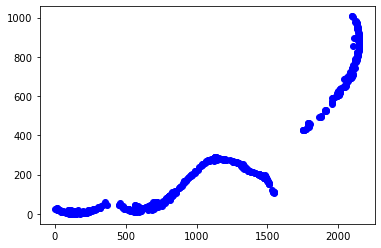

In [54]:
plt.figure()
for point in avg_coords:
    x = point[0]
    y = point[1]
    plt.plot(x,y,'bo')
plt.show()

...and it does! Finally, we can populate our 2D array with land and plot it.

In [55]:
for point in avg_coords:
    coast[point[0]][point[1]] = 1

(-20.0, 1000.0)

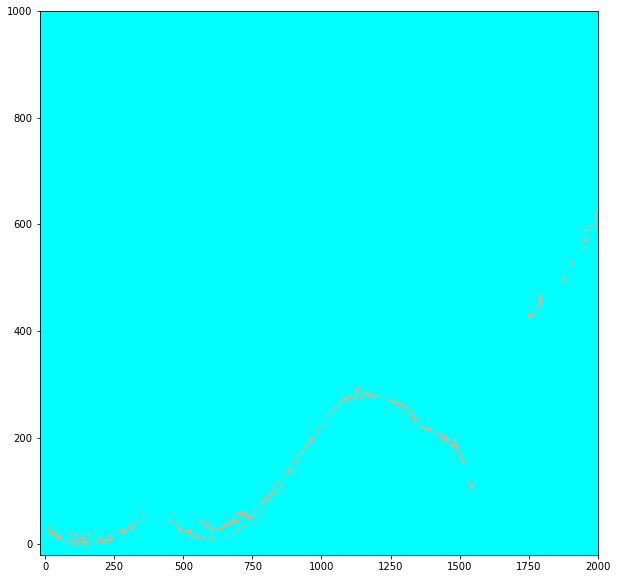

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import numpy as np

fig, ax = plt.subplots(1,figsize=(10,10))
points = {} # dictionary to keep track of patches by coordinates!
            # this only works because of the 2D array - no two circles
            # will ever have the same coordinates. hideous errors
            # would occur if not for this.
            
ax.set_facecolor('aqua')
            
for row in range(len(coast)):
    for col in range(len(coast[0])):
        if coast[row][col] == 1:
            p = mpatches.Circle((row, col), coast[row][col]*1.6, color="tan") # key = coords, val = patch object
            points[(row,col)] = p
            ax.add_patch(p)

plt.xlim([-20,2000])
plt.ylim([-20,1000])

Everything looks good - now let's plant some trees! We can introduce our functions from the `erosion_model` notebook. (Giant cell, but nothing new.)

In [37]:
import numpy as np

def timestep(coast):
    for row_idx in range(len(coast)): # loops to check every element
        for col_idx in range(len(coast[row_idx])): # in the 2d array.
            if coast[row_idx][col_idx] > 0: # if there is land, begin the coast checks
                # the coast checks are partitioned in this way to prevent index errors!
                # the top row checks only the left and right points
                if row_idx != 0:
                    if coast[row_idx-1][col_idx] <= 0:
                        if treemap[row_idx-1][col_idx]:
                            coast[row_idx][col_idx] -= 0.06
                        else:
                            coast[row_idx][col_idx] -= 0.16
                # the leftmost column checks only the right and front points
                if col_idx != 0:
                    if coast[row_idx][col_idx-1] <= 0:
                        if treemap[row_idx][col_idx-1]:
                            coast[row_idx][col_idx] -= 0.02
                        else:
                            coast[row_idx][col_idx] -= 0.06
                # the rightmost column checks only the left and front points
                if col_idx != len(coast[0])-1:
                    if coast[row_idx][col_idx+1] <= 0:
                        if treemap[row_idx][col_idx+1]:
                            coast[row_idx][col_idx] -= 0.02
                        else:
                            coast[row_idx][col_idx] -= 0.06
                
                if coast[row_idx][col_idx] < 0:  # fixes over-subtraction
                    coast[row_idx][col_idx] = 0
                    
def graphical_timestep(coast):
    timestep(coast)
    for row in range(len(coast)):
        for col in range(len(coast[0])):
            if coast[row][col] > 0:
                points[(row,col)].set_radius(3*coast[row][col]*0.8)
            
treemap = np.zeros((len(coast), len(coast[0])), dtype=bool)

def num_faces(coast, row, col):
    faces = 0
    if coast[row][col] == 0:
        if row-1 >= 0:
            if coast[row-1][col] > 0:
                faces += 1
        if row+1 <= len(coast)-1:
            if coast[row+1][col] > 0:
                faces += 1
        if col-1 >= 0:
            if coast[row][col-1] > 0:
                faces += 1
        if col+1 <= len(coast[0])-1:
            if coast[row][col+1] > 0:
                faces += 1
    return faces

def place_trees(coast, treemap, n):
    trees_to_place = n
    
    # first, check for four open faces (only possible with a mini lake, but still)
    for row_idx in range(len(coast)): # loops to check every element
        for col_idx in range(len(coast[row_idx])): # in the 2d array.
            if num_faces(coast,row_idx,col_idx) == 4:
                treemap[row_idx][col_idx] = True
                trees_to_place -= 1
                # also, we need to ensure we don't overplant.
                # check if we have any trees left after every planting -
                # if not, break immediately.
                if trees_to_place == 0:
                    return
    
    # next, check for three open faces.
    for row_idx in range(len(coast)): # loops to check every element
        for col_idx in range(len(coast[row_idx])): # in the 2d array.
            if num_faces(coast,row_idx,col_idx) == 3:
                treemap[row_idx][col_idx] = True
                trees_to_place -= 1
                if trees_to_place == 0:
                    return
    
    # now two open faces...
    for row_idx in range(len(coast)): # loops to check every element
        for col_idx in range(len(coast[row_idx])): # in the 2d array.
            if num_faces(coast,row_idx,col_idx) == 2:
                treemap[row_idx][col_idx] = True
                trees_to_place -= 1
                if trees_to_place == 0:
                    return
                
    # and one open face.
    for row_idx in range(len(coast)): # loops to check every element
        for col_idx in range(len(coast[row_idx])): # in the 2d array.
            if num_faces(coast,row_idx,col_idx) == 1:
                treemap[row_idx][col_idx] = True
                trees_to_place -= 1
                if trees_to_place == 0:
                    return

Let's start with 100 trees.

In [38]:
place_trees(coast,treemap,100)

(-20.0, 1000.0)

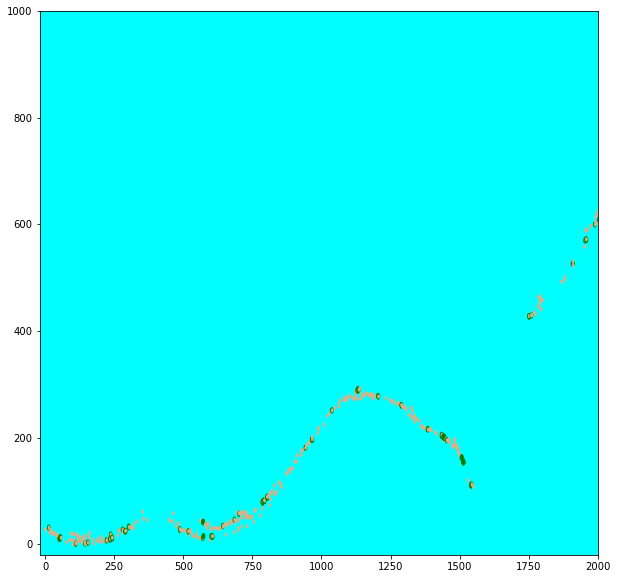

In [42]:
fig, ax = plt.subplots(1,figsize=(10,10))
points = {} # dictionary to keep track of patches by coordinates!
            # this only works because of the 2D array - no two circles
            # will ever have the same coordinates. hideous errors
            # would occur if not for this.
            
ax.set_facecolor('aqua')
            
for row in range(len(coast)):
    for col in range(len(coast[0])):
        if coast[row][col] == 1:
            p = mpatches.Circle((row, col), coast[row][col]*3, color="tan") # key = coords, val = patch object
            points[(row,col)] = p
            ax.add_patch(p)
        if treemap[row][col]:
            t = mpatches.Circle((row, col), 5, color="green")
            ax.add_patch(t)
plt.xlim([-20,2000])
plt.ylim([-20,1000])

The algorithm seems to work quite nicely. We can take a timestep and replot:

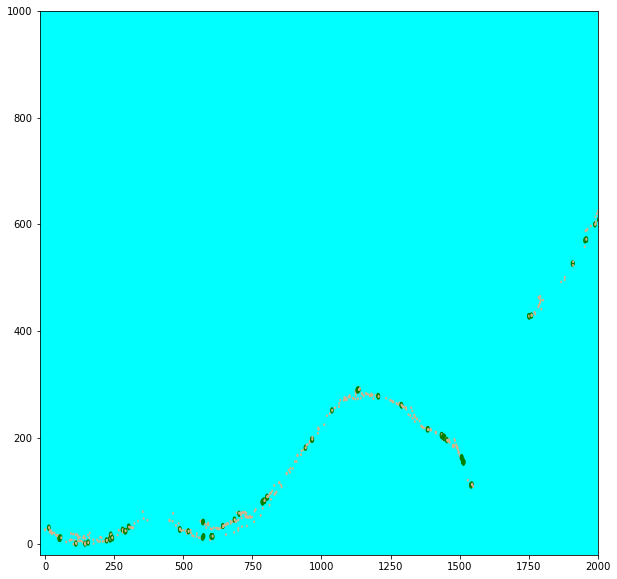

In [43]:
graphical_timestep(coast)
ax.figure

Tough to see at this scale, but one can certainly pick out the areas where landmass is shrinking most quickly and where the trees are most effectively protecting.

To do - add landmass graphs, more timesteps, different numbers of trees?
Code snippet graveyard, definitely delete this by Friday morning

In [18]:
#vertical extrapolation? not really needed in newest version
# for row in range(x_range):
#     for col in range(y_range):
#         if coast[row][col] == 1:
#             for i in range(y_range):
#                 coast[col][i] = 1


# to reset the 2d array:
# coast = [[0 for i in range(y_range+1)] for j in range(x_range+1)]
# for point in avg_coords:
#     coast[point[0]][point[1]] = 1